In [23]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [24]:
import pandas as pd

df = pd.read_csv("data/ExtractedTweets.csv")

democrat = df.query("Party == 'Democrat'").sample(30000)
republican = df.query("Party == 'Republican'").sample(30000)

df_slim = democrat.append(republican)
df_slim.head()
df = df_slim

### Extract tweet information

In [25]:
import re

def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

# make new columns for retweeted usernames, mentioned usernames and hashtags
df['retweeted'] = df['Tweet'].apply(find_retweeted)
df['mentioned'] = df['Tweet'].apply(find_mentioned)
df['hashtags'] = df['Tweet'].apply(find_hashtags)

print("Extracted tweet metadata")

Extracted tweet metadata


### Clean metioned, retweets and hashtags from tweet

In [26]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.append("rt")

def clean_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.sub('(?<=RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.sub('(?<!RT\\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

def clean(tweet):
    # Remove mentions, retweets and hashtags
    tweet = clean_hashtags(tweet)
    tweet = clean_mentioned(tweet)
    tweet = clean_retweeted(tweet)
    tweet = tweet.lower()
    # Remove punctuation
    tweet = re.sub("[\\-.,;:!/?]*", "", tweet)
    # Remove links
    tweet = re.sub(r"http\S+", "", tweet)
    # Remove stop words
    tweet = ' '.join([word for word in tweet.split(' ') if not word in stop_words])
    # Remove multiple spaces
    tweet = re.sub("\\s+", " ", tweet)
    return tweet

df['TweetCleaned'] = df['Tweet'].apply(clean)

print("Cleaned tweets")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dslh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned tweets


### Lemmatize the text

In [27]:
import spacy
# python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatization(tweet, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    doc = nlp(tweet)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return final

df['TweetCleaned'] = df['TweetCleaned'].apply(lemmatization)
print("Lemmatized tweets")

Lemmatized tweets


In [28]:
import gensim

def gen_words(tweet):
    # Use gensims simple simple_preprocess to remove accents, lowercase and tokenize
    return gensim.utils.simple_preprocess(tweet, deacc=True)

df['TweetWords'] = df['TweetCleaned'].apply(gen_words)

print("Generated tokens")

Generated tokens


In [29]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['TweetWords'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['TweetWords']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(tweetWords):
    return bigram[tweetWords]

def make_trigrams(bigrams):
    return trigram[bigram[bigrams]]

df['bigramms'] =  df['TweetWords'].apply(make_bigrams)
df['trigrams'] = df['bigramms'].apply(make_trigrams)

print("Generated trigrams")

Generated trigrams


### TF-IDF REMOVAL

In [30]:
from gensim.models import TfidfModel
import gensim.corpora as corpora

id2word = corpora.Dictionary(df['trigrams'])
corpus = [id2word.doc2bow(text) for text in df['trigrams']]
tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.15
words  = []
words_missing_in_tfidf = []

for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] # reinitialize to be safe.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # words with tf-idf score 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

# remove empty entries
corpus = [x for x in corpus if x != []]

print("TF-IDF removal")
print("Finish preprocessing")

TF-IDF removal
Finish preprocessing


Text(0.5, 1.0, 'Words removed from individual tweets proportional by their size.')

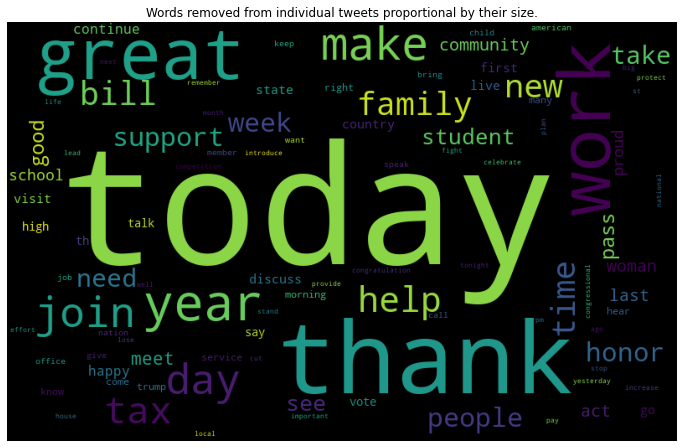

In [31]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(collocations=False, width = 800, height = 500).generate(" ".join(words))
plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Words removed from individual tweets proportional by their size.")

In [32]:
import pickle
file = open("data.bin", "wb")
pickle.dump((df, id2word, corpus, tfidf), file)
file.close()

In [33]:
import pickle
(df, id2word, corpus, tfidf) = pickle.load(open("data.bin", "rb"))

In [34]:
def get_document_topic(model, tri):
    doc_bow = id2word.doc2bow(tri)
    vec = model.get_document_topics(bow=doc_bow, minimum_probability=0)
    return [v for _, v in vec]

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

def evaluate_model(model):
    df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(model, trigram))
    df['len'] = df['topic_vec'].apply(lambda x: len(x))

    result = {}

    text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=101, test_size=0.30, shuffle=True)
    classifiers = [('MLP', MLPClassifier()), ('G-NB', GaussianNB()), ('L-SVM', LinearSVC())]
    for name, cl in classifiers:

        # Train and predict
        cl.fit(text_train.to_list(), label_train)

        prediction = cl.predict(text_test.to_list())

        # Confusion matrix
        confusion = confusion_matrix(label_test, prediction)
        # increase size of plot and fontsize for improved visibility
        #fig, ax_cm = plt.subplots(figsize=(10, 10))
        #plt.rcParams.update({'font.size': 14})
        # create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
        #plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Reds_r)
        # show plot corresponding to printed name and accuracy
        #plt.show()
        accuracy = accuracy_score(label_test, prediction)
        precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')
        result[name] = confusion, accuracy, precision, recall, fscore
    return result

In [36]:
import gensim
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexitiy_values = []
    model_list = []
    evaluations = []
    for num_topics in range(start, limit, step):
        print("########## Generated model with " + str(num_topics) + " topics ##########")
        model = gensim.models.LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=num_topics,
                    random_state=123,
                    per_word_topics=True,
                    # set workers to real CPU cores - 1
                    workers=7
                )
        model_list.append(model)
        perplexity = model.log_perplexity(corpus)
        print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.
        #coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        #coherence_values.append(coherencemodel.get_coherence())
        evaluation = evaluate_model(model)
        evaluations.append(evaluation)
        perplexitiy_values.append(perplexity)
        #print("Coherence: " + str(coherencemodel.get_coherence()))
        #print("Evaluation: \n" + str(evaluation))
        for classifier, eval in evaluation.items():
            confusion, accuracy, precision, recall, fscore = eval
            print(
            '''{name:5s} | Accuracy: {ac:1.10f}    Precision: {ps:1.10f}    Recall: {rc:1.10f}    F1: {f1:1.10f}'''.format(
                name=classifier,
                #confusion=confusion,
                ac=accuracy,
                ps=precision,
                rc=recall,
                f1=fscore
            ))

    return model_list, perplexitiy_values, evaluations


In [37]:
limit=180
start=5
step=5

model_list, perplexitiy_values, evaluations = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['trigrams'], start=start, limit=limit, step=step)

########## Generated model with 5 topics ##########
Perplexity:  -8.1740056318324
MLP   | Accuracy: 0.5658888889    Precision: 0.5665182333    Recall: 0.5657586398    F1: 0.5645876834
G-NB  | Accuracy: 0.5508888889    Precision: 0.5522007534    Recall: 0.5506805991    F1: 0.5474988114
L-SVM | Accuracy: 0.5226111111    Precision: 0.5231850661    Recall: 0.5223840473    F1: 0.5183400585
########## Generated model with 10 topics ##########
Perplexity:  -8.47745793179046
MLP   | Accuracy: 0.5971111111    Precision: 0.5992933610    Recall: 0.5972855196    F1: 0.5951335585
G-NB  | Accuracy: 0.5642777778    Precision: 0.5650235948    Recall: 0.5643980762    F1: 0.5632785470
L-SVM | Accuracy: 0.5444444444    Precision: 0.5446844032    Recall: 0.5443368822    F1: 0.5435062992
########## Generated model with 15 topics ##########
Perplexity:  -8.696257522766363
MLP   | Accuracy: 0.5926666667    Precision: 0.5938365342    Recall: 0.5927959619    F1: 0.5915857858
G-NB  | Accuracy: 0.5494444444    P

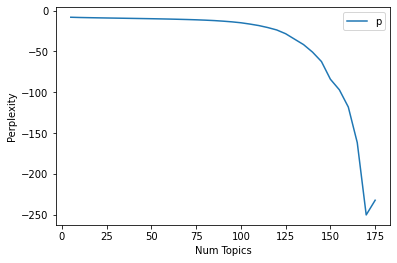

In [38]:
import matplotlib.pyplot as plt

# Create Perplexity Plot for topic numbers
x = range(start, limit, step)
plt.plot(x, perplexitiy_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend("perplexitiy_values", loc='best')
plt.savefig("img/topic_count.pdf")
plt.show()

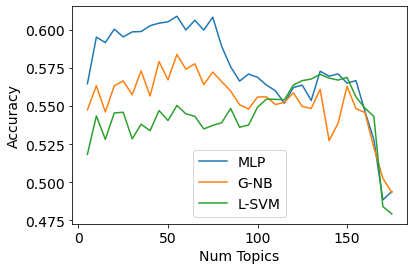

In [46]:
# Create classifier comparision for multiple scores
# Hint: You need to change the respective variables in line 8 and the figure labels
scores = {name: [] for name in evaluations[0].keys()}
for evaluation in evaluations:
    for name, ev in evaluation.items():
    # evaluation: confusion, accuracy, precision, recall, fscore
        confusion, accuracy, precision, recall, fscore = ev
        scores[name].append(fscore)

for label, score in scores.items():
    plt.plot(x, score, label = label)
plt.xlabel("Num Topics")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("img/topic_confusion.pdf")
plt.show()

range(5, 180, 5)


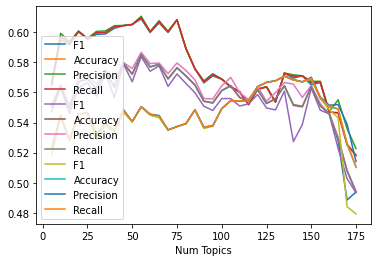

In [40]:
# Create a summary for each classifier

names = evaluations[0].keys()
x = range(5, 180, 5)
plt.clf()

# Create summary figure for all classifiers separately
for name in names:
    f1 = []
    acc = []
    pre = []
    rec = []
    evs = []

    for evaluation in evaluations:
        for inner_name, ev in evaluation.items():
            if inner_name == name:
                evs.append(ev)
    for ev in evs[:40]:
    # evaluation: confusion, accuracy, precision, recall, fscore
        confusion, accuracy, precision, recall, fscore = ev

        f1.append(fscore)
        acc.append(accuracy)
        pre.append(precision)
        rec.append(recall)
    plt.plot(x, f1, label = 'F1')
    plt.plot(x, acc, label = 'Accuracy')
    plt.plot(x, pre, label = 'Precision')
    plt.plot(x, rec, label = 'Recall')
    plt.xlabel("Num Topics")
    plt.ylabel("")
    plt.legend()
    plt.savefig("img/summary_" + name.lower() + ".pdf")
    #plt.clf()

In [47]:
import gensim

lda_model = gensim.models.LdaMulticore(
                corpus=corpus[:-1],
                id2word=id2word,
                num_topics=60,
                random_state=123,
                per_word_topics=False,
                workers=7
            )

Training classifier
Confusion:
 [[5432 3546]
 [3549 5473]]
Accuracy: 0.6058333333333333
Precision: 0.605831224753977
Recall: 0.6058313854616119
F1Score: 0.6058312882789987


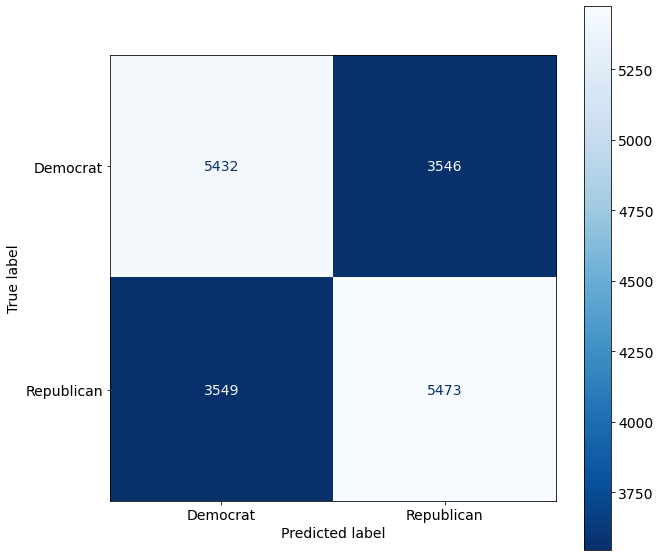

In [48]:
# Rerun the classifier on the new dataset

df['topic_vec'] = df['trigrams'].apply(lambda trigram: get_document_topic(lda_model, trigram))
df['len'] = df['topic_vec'].apply(lambda x: len(x))

print('Training classifier')
text_train, text_test, label_train, label_test = train_test_split(df["topic_vec"], df['Party'], train_size=0.70, random_state=123, test_size=0.30, shuffle=True)
cl = MLPClassifier()

# Train and predict
cl.fit(text_train.to_list(), label_train)
prediction = cl.predict(text_test.to_list())

# Confusion matrix
confusion = confusion_matrix(label_test, prediction)
accuracy = accuracy_score(label_test, prediction)
precision, recall, fscore, *rest = precision_recall_fscore_support(label_test, prediction, average='macro')

print("Confusion:\n " + str(confusion))
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1Score: " + str(fscore))

# increase size of plot and fontsize for improved visibility
fig, ax_cm = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 14})
# create plot for multi-class confusion matrix, use prepared axes object and change colormap for better contrast
plot_confusion_matrix(cl, text_test.to_list(), label_test.to_list(), ax=ax_cm, cmap=plt.cm.Blues_r)
# show plot corresponding to printed name and accuracy
plt.savefig("img/lvm_summary_130.pdf")
plt.show()

In [54]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

test


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.033481  0.030642       1        1  2.184611
28     0.236962  0.043214       2        1  2.174080
24    -0.083007  0.112285       3        1  2.100625
55    -0.242513 -0.039750       4        1  2.069903
27     0.144441 -0.130616       5        1  1.960560
4      0.109940 -0.205226       6        1  1.936517
21    -0.088477 -0.081545       7        1  1.913702
1      0.165610  0.201792       8        1  1.902396
43     0.065929  0.084794       9        1  1.894903
10     0.053736 -0.059507      10        1  1.858838
0      0.198394 -0.031624      11        1  1.847903
6     -0.004175  0.217724      12        1  1.830294
51     0.164129  0.138867      13        1  1.797851
13    -0.179111  0.094177      14        1  1.792397
23     0.031012  0.121130      15        1  1.769246
25    -0.163995  0.131652      16        1  1.758769
56    -0.152957 -0.004138      17        1  1.751005
57    -0.105542  0.061468      18        1  1.733006
37     0.090476  0.012773      19        1  1.731948
35    -0.013996 -0.096849      20        1  1.729100
52     0.204254  0.015655      21        1  1.720320
5      0.102362  0.141861      22        1  1.692591
54     0.114926  0.081704      23        1  1.680853
11    -0.231531  0.007297      24        1  1.669099
53     0.068761 -0.086949      25        1  1.665940
30    -0.019782 -0.236039      26        1  1.663072
49    -0.119566 -0.178458      27        1  1.651027
50     0.188690 -0.150327      28        1  1.624498
44    -0.032394  0.142462      29        1  1.619083
39     0.052361 -0.190935      30        1  1.599922
15    -0.182413  0.040568      31        1  1.594023
29     0.069047 -0.249830      32        1  1.593856
2      0.158100  0.071108      33        1  1.593623
26    -0.017697  0.078375      34        1  1.587578
48     0.188788 -0.097446      35        1  1.585907
59    -0.069286 -0.149914      36        1  1.584840
58    -0.147730  0.191428      37        1  1.584297
7      0.155773  0.002290      38        1  1.577033
36    -0.202279 -0.118122      39        1  1.570236
47    -0.109153 -0.025945      40        1  1.566374
3     -0.118920  0.151743      41        1  1.565701
32    -0.086089 -0.222558      42        1  1.564081
38    -0.171574 -0.167569      43        1  1.543243
18     0.231344 -0.073568      44        1  1.530422
33     0.011533  0.179825      45        1  1.528305
19     0.113000 -0.055491      46        1  1.520910
12     0.016663 -0.168558      47        1  1.509779
45    -0.226842  0.077717      48        1  1.503792
41    -0.004021 -0.036937      49        1  1.485820
42     0.071625  0.190902      50        1  1.484417
22     0.075124  0.239832      51        1  1.482559
40    -0.077848  0.197697      52        1  1.476711
17    -0.073798  0.255650      53        1  1.466741
8      0.116797 -0.158021      54        1  1.461826
46     0.206570  0.104288      55        1  1.460936
20    -0.135185 -0.123542      56        1  1.457878
14    -0.034947 -0.186810      57        1  1.457325
31    -0.062689 -0.036726      58        1  1.452340
16    -0.211864 -0.077363      59        1  1.447587
34    -0.070445  0.019439      60        1  1.437801, topic_info=          Term         Freq        Total Category  logprob  loglift
29         tax  2515.000000  2515.000000  Default  30.0000  30.0000
1690    reform   929.000000   929.000000  Default  29.0000  29.0000
1743  chairman   500.000000   500.000000  Default  28.0000  28.0000
45       great  2573.000000  2573.000000  Default  27.0000  27.0000
121      today  2879.000000  2879.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
170      first    24.609476  1005.710706  Topic60  -5.4759   0.5317
401       keep    24.123546   938.452017  Topic60  -5.4959   0.5810
45       great    25.605198  2573.326335  Topic60  -5.4363 